Example of running an analysis using the pytetrad_plus package.



In [1]:
# read data

from pytetrad_plus import MyTetradSearch
import pprint

ts = MyTetradSearch()

DIR='pytetrad_plus'
# read data
df = ts.read_csv(f'{DIR}/boston_data_raw.csv')

df

,alcohol_bev,TIB,TST,PANAS_PA,PANAS_NA,worry_scale,PHQ9
0,1.0,9.00,7.333333,44.0,13.0,8.0,0.0
1,0.0,10.25,8.750000,40.0,12.0,14.0,0.0
2,1.0,8.50,7.166667,39.0,12.0,15.0,0.0
3,1.0,8.75,8.083333,39.0,12.0,12.0,0.0
4,1.0,8.25,6.666667,38.0,13.0,15.0,0.0
...,...,...,...,...,...,...,...
636,4.0,8.75,7.916667,29.0,12.0,17.0,3.0
637,4.0,8.50,7.666667,31.0,12.0,17.0,4.0
638,3.0,8.50,7.583333,33.0,13.0,17.0,3.0
639,3.0,9.00,8.166667,31.0,12.0,19.0,2.0


In [2]:
# add the lag columns
df_lag = ts.add_lag_columns(df, lag_stub='_lag')
# standardize the data
df_lag_std = ts.standardize_df_cols(df_lag)

print(f"DataFrame loaded and lag columns added, columns standardized. Number of rows: {len(df_lag)}")
df_lag

DataFrame loaded and lag columns added, columns standardized. Number of rows: 640


,alcohol_bev,TIB,TST,PANAS_PA,PANAS_NA,worry_scale,PHQ9,alcohol_bev_lag,TIB_lag,TST_lag,PANAS_PA_lag,PANAS_NA_lag,worry_scale_lag,PHQ9_lag
0,0.0,10.25,8.750000,40.0,12.0,14.0,0.0,1.0,9.00,7.333333,44.0,13.0,8.0,0.0
1,1.0,8.50,7.166667,39.0,12.0,15.0,0.0,0.0,10.25,8.750000,40.0,12.0,14.0,0.0
2,1.0,8.75,8.083333,39.0,12.0,12.0,0.0,1.0,8.50,7.166667,39.0,12.0,15.0,0.0
3,1.0,8.25,6.666667,38.0,13.0,15.0,0.0,1.0,8.75,8.083333,39.0,12.0,12.0,0.0
4,0.0,8.25,7.416667,37.0,12.0,16.0,0.0,1.0,8.25,6.666667,38.0,13.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,4.0,8.75,7.916667,29.0,12.0,17.0,3.0,6.0,7.00,6.166667,31.0,15.0,18.0,3.0
636,4.0,8.50,7.666667,31.0,12.0,17.0,4.0,4.0,8.75,7.916667,29.0,12.0,17.0,3.0
637,3.0,8.50,7.583333,33.0,13.0,17.0,3.0,4.0,8.50,7.666667,31.0,12.0,17.0,4.0
638,3.0,9.00,8.166667,31.0,12.0,19.0,2.0,3.0,8.50,7.583333,33.0,13.0,17.0,3.0


In [3]:

# load prior
prior_lines = ts.read_prior_file(f'{DIR}/boston_prior.txt')
# extract knowledge
knowledge = ts.extract_knowledge(prior_lines)
pprint.pprint(knowledge)

ts.load_knowledge(knowledge)

searchResult = ts.run_model_search(df_lag_std, 
                                    model='gfci',
                                    knowledge=knowledge,
                                    score={'sem_bic': {'penalty_discount': 1.0}},
                                    test={'fisher_z': {'alpha': .05}})

edges = list(searchResult['setEdges'])
pprint.pprint(edges)

{'addtemporal': {0: ['alcohol_bev_lag',
                     'TIB_lag',
                     'TST_lag',
                     'PANAS_PA_lag',
                     'PANAS_NA_lag',
                     'worry_scale_lag',
                     'PHQ9_lag'],
                 1: ['alcohol_bev',
                     'TIB',
                     'TST',
                     'PANAS_PA',
                     'PANAS_NA',
                     'worry_scale',
                     'PHQ9']}}
['PHQ9_lag --> PHQ9',
 'PANAS_PA_lag <-> PHQ9_lag',
 'PANAS_NA <-> PANAS_NA_lag',
 'TIB_lag o-o TST_lag',
 'PANAS_NA --> worry_scale',
 'worry_scale_lag o-> worry_scale',
 'PHQ9 --> PANAS_PA',
 'alcohol_bev_lag o-> alcohol_bev',
 'TST_lag o-> TST',
 'worry_scale --> PANAS_PA',
 'PANAS_PA <-> PANAS_PA_lag',
 'PHQ9 --> PANAS_NA',
 'TIB_lag o-> TIB',
 'TIB <-> TST',
 'PANAS_NA_lag <-> PHQ9_lag']


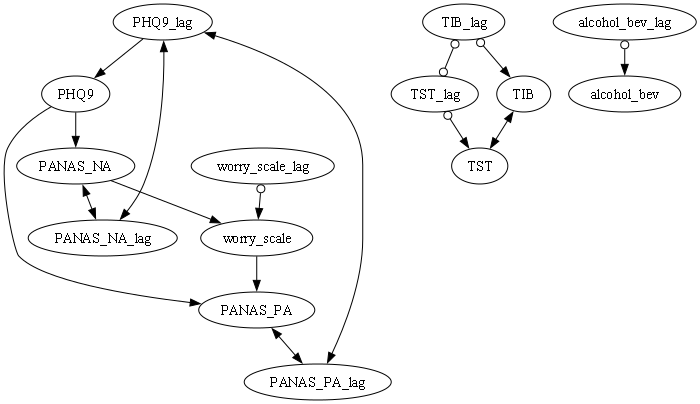

In [4]:
from dgraph_flex import DgraphFlex
# create graph output
obj = DgraphFlex()

# add the edges
obj.add_edges(edges)
# show the graph
obj.show_graph()

In [5]:
# run the sem
import semopy

lavaan_model = ts.edges_to_lavaan(edges)
    
# run semopy
sem_results = ts.run_semopy(lavaan_model, df_lag_std)

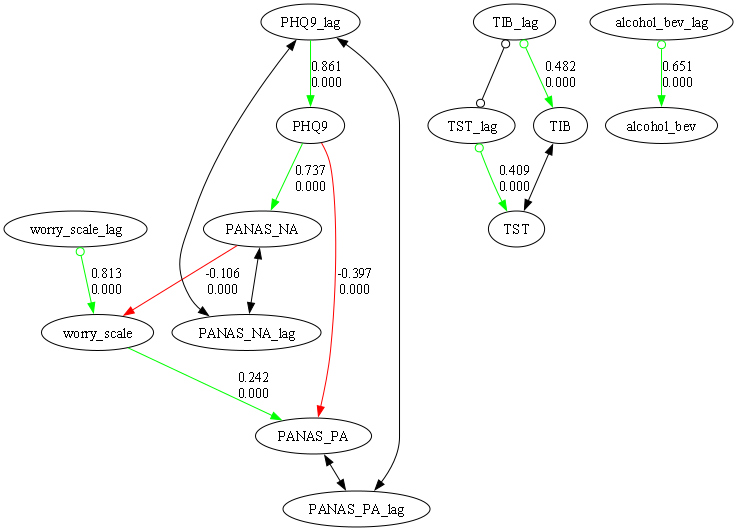

In [6]:
# add sem results to existing graph

ts.add_sem_results_to_graph(obj, sem_results['estimates'])
obj.show_graph()

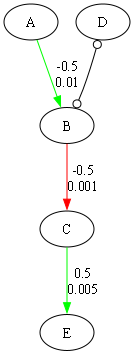

In [7]:
# example of creating a graph with DgraphFlex
from dgraph_flex import DgraphFlex

obj = DgraphFlex()
# add edges to graph object
obj.add_edge('A', '-->', 'B', color='green', strength=-0.5, pvalue=0.01)
obj.add_edge('B', '-->', 'C', color='red', strength=-.5, pvalue=0.001)
obj.add_edge('C', '-->', 'E', color='green', strength=0.5, pvalue=0.005)
obj.add_edge('D', 'o-o', 'B')
# load into graphviz object and render to window
obj.show_graph()
